In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dataset-enco/test (1)/test/Fear/1.jpg
/kaggle/input/dataset-enco/test (1)/test/Fear/3.jpg
/kaggle/input/dataset-enco/test (1)/test/Fear/2.jpg
/kaggle/input/dataset-enco/test (1)/test/Angry/6.jpg
/kaggle/input/dataset-enco/test (1)/test/Angry/5.jpg
/kaggle/input/dataset-enco/test (1)/test/Angry/8.jpg
/kaggle/input/dataset-enco/test (1)/test/Angry/10.jpg
/kaggle/input/dataset-enco/test (1)/test/Angry/9.jpg
/kaggle/input/dataset-enco/test (1)/test/Angry/1.jpg
/kaggle/input/dataset-enco/test (1)/test/Angry/7.jpg
/kaggle/input/dataset-enco/test (1)/test/Angry/11.jpg
/kaggle/input/dataset-enco/test (1)/test/Angry/4.jpg
/kaggle/input/dataset-enco/test (1)/test/Angry/3.jpg
/kaggle/input/dataset-enco/test (1)/test/Angry/2.jpg
/kaggle/input/dataset-enco/test (1)/test/Neutral/45.jpg
/kaggle/input/dataset-enco/test (1)/test/Neutral/20.jpg
/kaggle/input/dataset-enco/test (1)/test/Neutral/6.jpg
/kaggle/input/dataset-enco/test (1)/test/Neutral/5.jpg
/kaggle/input/dataset-enco/test (1)/t

In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import os
from torchvision import datasets
from torch.utils.data import DataLoader

In [9]:
import torch
import torch.nn as nn

# Define CNN Encoder
class CNN_Encoder(nn.Module):
    def __init__(self, num_classes):
        super(CNN_Encoder, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.fc = nn.Conv2d(256, num_classes, kernel_size=1)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.pool(nn.ReLU()(self.conv2(nn.ReLU()(self.conv1(x)))))
        x = self.pool(nn.ReLU()(self.conv4(nn.ReLU()(self.conv3(x)))))
        x = self.fc(x)
        x = self.softmax(x)
        return x

# Define Deconvolutional Decoder
class Deconv_Decoder(nn.Module):
    def __init__(self, num_classes):
        super(Deconv_Decoder, self).__init__()
        self.deconv1 = nn.ConvTranspose2d(num_classes, 256, kernel_size=3, padding=1)
        self.deconv2 = nn.ConvTranspose2d(256, 128, kernel_size=3, padding=1)
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')
        self.deconv3 = nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1)
        self.deconv4 = nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1)
        self.conv = nn.Conv2d(32, num_classes, kernel_size=1)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.upsample(nn.ReLU()(self.deconv2(nn.ReLU()(self.deconv1(x)))))
        x = self.upsample(nn.ReLU()(self.deconv4(nn.ReLU()(self.deconv3(x)))))
        x = self.conv(x)
        x = self.softmax(x)
        return x

# Combine Encoder and Decoder
class CNN_Deconv_Model(nn.Module):
    def __init__(self, num_classes):
        super(CNN_Deconv_Model, self).__init__()
        self.encoder = CNN_Encoder(num_classes)
        self.decoder = Deconv_Decoder(num_classes)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Example usage
num_classes = 5
model = CNN_Deconv_Model(num_classes)

# Example input
example_input = torch.randn(1, 3, 224, 224)  # Assuming input size of 64x64
output = model(example_input)
print(output.size())  # Check output size


torch.Size([1, 5, 224, 224])


In [4]:
batch_size = 8
num_classes = 3
learning_rate = 0.001
num_epochs = 20

In [10]:
!pip install torchinfo
from torchinfo import summary

In [11]:
summary(model, input_size=(3,32,32))

Layer (type:depth-idx)                   Output Shape              Param #
CNN_Deconv_Model                         [5, 8, 32]                --
├─CNN_Encoder: 1-1                       [5, 8, 8]                 --
│    └─Conv2d: 2-1                       [32, 32, 32]              896
│    └─Conv2d: 2-2                       [64, 32, 32]              18,496
│    └─MaxPool2d: 2-3                    [64, 16, 16]              --
│    └─Conv2d: 2-4                       [128, 16, 16]             73,856
│    └─Conv2d: 2-5                       [256, 16, 16]             295,168
│    └─MaxPool2d: 2-6                    [256, 8, 8]               --
│    └─Conv2d: 2-7                       [5, 8, 8]                 1,285
│    └─Softmax: 2-8                      [5, 8, 8]                 --
├─Deconv_Decoder: 1-2                    [5, 8, 32]                --
│    └─ConvTranspose2d: 2-9              [256, 8, 8]               11,776
│    └─ConvTranspose2d: 2-10             [128, 8, 8]            

In [7]:
!pip install torchsummary
from torchsummary import summary


RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data_dir = f"/kaggle/input"

In [13]:
all_transforms = transforms.Compose([transforms.Resize((32,32)),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                                                          std=[0.2023, 0.1994, 0.2010])
                                     ])
# Create Training dataset (replace with your custom dataset class if necessary)
train_dataset = torchvision.datasets.ImageFolder( root=os.path.join(data_dir, "/kaggle/input/dataset-enco/train/train"),  # Path to training images folder
                                                  transform=all_transforms)


# Create Testing dataset (replace with your custom dataset class if necessary)
test_dataset = torchvision.datasets.ImageFolder(root=os.path.join(data_dir, "/kaggle/input/dataset-enco/test (1)/test"),  # Path to testing images folder
                                                transform=all_transforms)

# Instantiate loader objects
train_loader = torch.utils.data.DataLoader( dataset=train_dataset, batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


In [15]:
model = ConvNeuralNet(num_classes)

# Set Loss function with criterion
criterion = nn.CrossEntropyLoss()

# Set optimizer with optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)  

total_step = len(train_loader)

In [16]:
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
     # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        model = model.to(device)
     
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
    
       # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))


Epoch [1/20], Loss: 1.6591
Epoch [2/20], Loss: 1.6246
Epoch [3/20], Loss: 1.6320
Epoch [4/20], Loss: 1.5554
Epoch [5/20], Loss: 1.9456
Epoch [6/20], Loss: 1.2873
Epoch [7/20], Loss: 1.7201
Epoch [8/20], Loss: 1.7944
Epoch [9/20], Loss: 1.1865
Epoch [10/20], Loss: 1.3276
Epoch [11/20], Loss: 1.2477
Epoch [12/20], Loss: 1.7526
Epoch [13/20], Loss: 1.2823
Epoch [14/20], Loss: 0.8032
Epoch [15/20], Loss: 1.1441
Epoch [16/20], Loss: 2.3308
Epoch [17/20], Loss: 0.4709
Epoch [18/20], Loss: 2.9637
Epoch [19/20], Loss: 1.0421
Epoch [20/20], Loss: 0.1371


In [17]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    print('Accuracy of the network on the {} train images: {} %'.format(50000, 100 * correct / total))




Accuracy of the network on the 50000 train images: 77.04280155642023 %


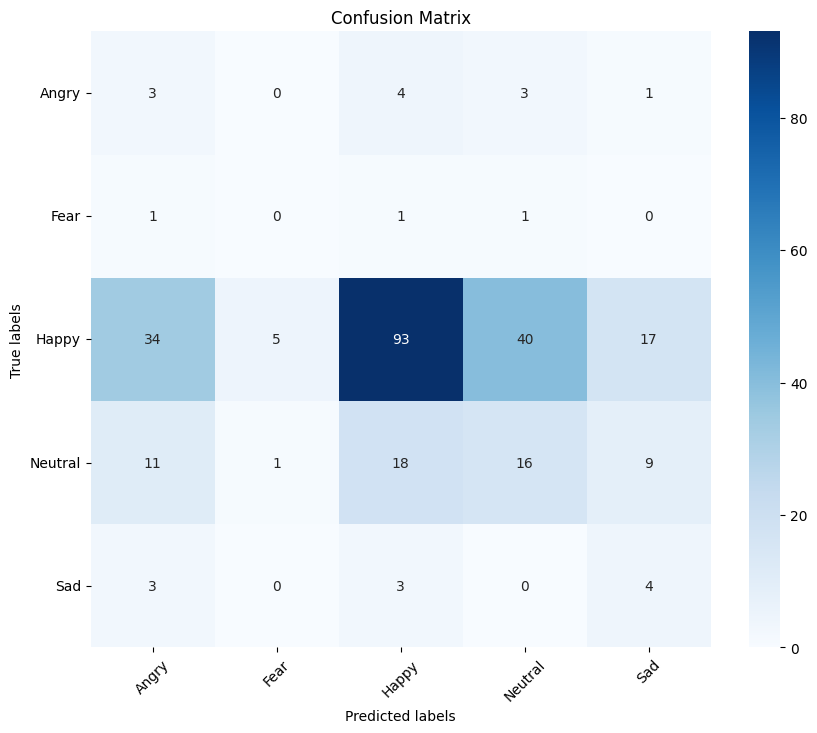

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Evaluate the model on the test dataset
model.eval()
predictions = []
true_labels = []

# Iterate through the test dataset
for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    predictions.extend(predicted.cpu().numpy())
    true_labels.extend(labels.cpu().numpy())

# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)

# Define class labels
class_names = test_dataset.classes

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()
